In [4]:
import os
import re
import itertools
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
from itertools import combinations
from sklearn.base import clone
from xgboost import XGBClassifier
import itertools
import warnings

In [5]:
file_path = "master.csv"
df = pd.read_csv(file_path)

block_dfs = {}
for block in sorted(df['subexperiment_number'].unique()):
    block_df = df[df['subexperiment_number'] == block].copy()
    block_df = block_df.sort_values('participant_number').reset_index(drop=True)
    block_dfs[block] = block_df

In [12]:
base_param_grids = {
    "Logistic Regression": {
        "C":       np.logspace(-3, 3, 10),
        "penalty": ["l2"],
        "solver":  ["lbfgs"],
    },
    "LDA": {
        "solver":    ["svd", "lsqr", "eigen"],
        "shrinkage": [None, "auto", 0.1, 0.3, 0.5, 0.7, 0.9],
    },
    "Random Forest": {
        "n_estimators":     [50, 100, 200, 300],
        "max_depth":        [None, 10, 20, 30],
        "min_samples_split":[2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap":        [True, False],
    },
    "SVM": {
        "C":      np.logspace(-3, 3, 10),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma":  ["scale", "auto"],
    },
    "Decision Tree": {
        "max_depth":        [None, 10, 20, 30],
        "min_samples_split":[2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights":     ["uniform", "distance"],
        "metric":      ["euclidean", "manhattan"],
    },
    "XGBoost": {
    "n_estimators":    [50, 100, 200],
    "max_depth":       [3, 5, 7],
    "learning_rate":   [0.01, 0.1, 0.2],
    "subsample":       [0.6, 0.8, 1.0],
    "colsample_bytree":[0.6, 0.8, 1.0],
    "reg_alpha":       [0, 0.1, 1],
    "reg_lambda":      [1, 5, 10],
    }
}

features_H1 = [                         
    "accuracy_subexperiment",
    "trial_duration_mean",
    #"trial_duration_std",
]
features_H2 = [                         
    "nback_composite_2",
    "MRTAcc",
]
features_H3 = features_H1 + features_H2 

def mean_ci(arr, alpha=0.05):
    arr = np.asarray(arr)
    lower = np.percentile(arr, 100 * alpha / 2)
    upper = np.percentile(arr, 100 * (1 - alpha / 2))
    return arr.mean(), lower, upper

def run_pipeline(run_tag, feat_cols):   
    print(f"\n======== Running {run_tag} ========") 

    X_block = df_all[feat_cols].copy()  
    y_block = df_all[label].copy()

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("  Model: Dummy Baseline (stratified)")
    dummy = DummyClassifier(strategy="stratified", random_state=42)

    bl_f1, bl_acc, bl_prec, bl_rec = [], [], [], []
    for tr_idx, te_idx in outer_cv.split(X_block, y_block):
        X_tr, X_te = X_block.iloc[tr_idx], X_block.iloc[te_idx]
        y_tr, y_te = y_block.iloc[tr_idx], y_block.iloc[te_idx]

        dummy.fit(X_tr, y_tr)
        y_pred = dummy.predict(X_te)

        bl_f1.append(f1_score(y_te, y_pred, average="weighted"))
        bl_acc.append(accuracy_score(y_te, y_pred))
        bl_prec.append(precision_score(y_te, y_pred, average="weighted", zero_division=0))
        bl_rec.append(recall_score(y_te, y_pred, average="weighted"))

    for name_, arr_ in [("Baseline F1", bl_f1), ("Baseline Accuracy", bl_acc),
                        ("Baseline Precision", bl_prec), ("Baseline Recall", bl_rec)]:
        m, l, u = mean_ci(arr_)
        print(f"    {name_:<19}= {m:.4f} [{l:.4f}, {u:.4f}]")

    classifiers_to_tune = [
        ("Logistic Regression",
         LogisticRegression(class_weight="balanced", max_iter=1000)),
        ("LDA",           LinearDiscriminantAnalysis()),
        ("Random Forest", RandomForestClassifier(class_weight="balanced",
                                                 random_state=42)),
        ("SVM",           SVC(class_weight="balanced", probability=True,
                              random_state=42)),
        ("Decision Tree", DecisionTreeClassifier(class_weight="balanced",
                                                 random_state=42)),
        ("KNN",           KNeighborsClassifier()),
        ("XGBoost",       XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                        random_state=42)),
    ]

    for clf_name, clf in classifiers_to_tune:
        print(f"  Model: {clf_name}")
        base_clf = clone(clf)
        pg_pref = {f"model__{k}": v
                   for k, v in base_param_grids[clf_name].items()}
        y_true_all, y_pred_all = [], []

        pipe = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("model",  base_clf),
        ])

        search = RandomizedSearchCV(
            pipe, param_distributions=pg_pref, n_iter=100, cv=5,
            scoring="f1_weighted", random_state=42, n_jobs=-1,
        )

        tr_f1, tr_acc, tr_prec, tr_rec = [], [], [], []
        te_f1, te_acc, te_prec, te_rec = [], [], [], []

        for tr_idx, te_idx in outer_cv.split(X_block, y_block):
            X_tr, X_te = X_block.iloc[tr_idx], X_block.iloc[te_idx]
            y_tr, y_te = y_block.iloc[tr_idx], y_block.iloc[te_idx]

            fold_clf = clone(clf)
            pipe.set_params(model=fold_clf)
            search.estimator = pipe

            search.fit(X_tr, y_tr)
            best_pipe = search.best_estimator_

            y_tr_pred = best_pipe.predict(X_tr)
            y_te_pred = best_pipe.predict(X_te)
            
            tr_f1.append(f1_score(y_tr, y_tr_pred, average="weighted"))
            te_f1.append(f1_score(y_te, y_te_pred, average="weighted"))
            tr_acc.append(accuracy_score(y_tr, y_tr_pred))
            te_acc.append(accuracy_score(y_te, y_te_pred))
            tr_prec.append(precision_score(y_tr, y_tr_pred, average="weighted", zero_division=0))
            te_prec.append(precision_score(y_te, y_te_pred, average="weighted", zero_division=0))
            tr_rec.append(recall_score(y_tr, y_tr_pred, average="weighted"))
            te_rec.append(recall_score(y_te, y_te_pred, average="weighted"))

            y_true_all.extend(y_te); y_pred_all.extend(y_te_pred)

        for name_, arr_ in [("Training F1", tr_f1), ("Training Accuracy", tr_acc),
                            ("Training Precision", tr_prec), ("Training Recall", tr_rec),
                            ("Test F1", te_f1), ("Test Accuracy", te_acc),
                            ("Test Precision", te_prec), ("Test Recall", te_rec)]:
            m, l, u = mean_ci(arr_)
            print(f"    {name_:<17}= {m:.4f} [{l:.4f}, {u:.4f}]")

        cm = confusion_matrix(y_true_all, y_pred_all)
        confusion_matrices[f"{run_tag}_{clf_name}"] = cm  

        print(f"    Best params: {search.best_params_}")

        best_est = best_pipe.named_steps["model"]
        if hasattr(best_est, "feature_importances_") or hasattr(best_est, "coef_"):
            if hasattr(best_est, "feature_importances_"):
                importances = best_est.feature_importances_
            else:
                importances = np.abs(best_est.coef_).ravel()
            fi = pd.Series(importances, index=feat_cols).sort_values(ascending=False)
            print("    Feature importances:")
            for fname, fval in fi.items():
                print(f"      {fname}: {fval:.4f}")

        if clf_name == "Logistic Regression":
            fresh_lr = clone(clf)
            best_pipe.fit(X_block, y_block)
            scaler = best_pipe.named_steps["scaler"]
            X_std  = scaler.transform(X_block)
            fresh_lr.fit(X_std, y_block)  
            X_sm   = sm.add_constant(X_std)          
            logit  = sm.Logit(y_block.values, X_sm).fit(disp=False)
            print("    Coef (β) ± p‑value:")
            for feat_lbl, beta, p in zip(
                    ["Intercept"]+feat_cols, logit.params, logit.pvalues):
                print(f"      {feat_lbl:<25} {beta:+.3f}  (p={p:.3f})")

warnings.filterwarnings("ignore")
master_df = pd.read_csv("master.csv")
confusion_matrices = {}

labels = ["tutorial_split_feedback_score_subexperiment"]

for label in labels:                    
    if label not in master_df.columns:
        print(f"Label '{label}' not found, skipping.");  continue
    df_all = master_df.dropna(subset=[label])
    if df_all[label].nunique() < 2:
        print(f"Skipping {label} (one class only)");     continue

    run_pipeline("H1_states",  features_H1)  
    run_pipeline("H2_traits",  features_H2)   

    h2b_acc = smf.ols('accuracy_subexperiment ~ nback_composite_2 + MRTAcc', data=df_all).fit()
    print("--- H2b: Accuracy predicted by traits ---")
    print(h2b_acc.summary())
    h2b_rt = smf.ols('trial_duration_mean ~ nback_composite_2 + MRTAcc', data=df_all).fit()
    print("--- H2b: Response time predicted by traits ---")
    print(h2b_rt.summary())
    model_acc = smf.ols('accuracy_subexperiment ~ nback_composite_2 + MRTAcc', data=df_all).fit()
    print("--- H2b: Predicting Accuracy from Traits (H2b) ---")
    print(model_acc.summary())
    model_rt = smf.ols('trial_duration_mean ~ nback_composite_2 + MRTAcc', data=df_all).fit()
    print("--- H2b: Predicting Response Time from Traits (H2b) ---")
    print(model_rt.summary())    

    print("\n======== Running H3 Interaction (states × traits) ========")  
    
    df_int = df_all.copy()
    for a, b in combinations(features_H3, 2):
        if (a in features_H1 and b in features_H2) or (a in features_H2 and b in features_H1):
            col_name = f"{a}*{b}"
            df_int[col_name] = df_int[a] * df_int[b]     

    X_h3 = df_int[features_H3 + [c for c in df_int.columns if "*" in c]]
    y_h3 = df_int[label]

    scaler_h3 = StandardScaler().fit(X_h3)
    X_std = scaler_h3.transform(X_h3)
    X_sm  = sm.add_constant(X_std)
    logit = sm.Logit(y_h3.values, X_sm).fit(disp=False)

    print("  H3 Coefficients (β) ± p‑values")
    for feat_lbl, beta, p in zip(["Intercept"]+list(X_h3.columns),
                                 logit.params, logit.pvalues):
        print(f"    {feat_lbl:<25} {beta:+.3f}  (p={p:.3f})")


======== Running H1_states ========
  Model: Dummy Baseline (stratified)
    Baseline F1        = 0.6466 [0.6113, 0.6800]
    Baseline Accuracy  = 0.6500 [0.6062, 0.6854]
    Baseline Precision = 0.6437 [0.6130, 0.6751]
    Baseline Recall    = 0.6500 [0.6062, 0.6854]
  Model: Logistic Regression
    Training F1      = 0.5840 [0.5699, 0.5952]
    Training Accuracy= 0.5479 [0.5339, 0.5596]
    Training Precision= 0.7020 [0.6848, 0.7135]
    Training Recall  = 0.5479 [0.5339, 0.5596]
    Test F1          = 0.5893 [0.5298, 0.6354]
    Test Accuracy    = 0.5563 [0.4937, 0.6021]
    Test Precision   = 0.7176 [0.6802, 0.7809]
    Test Recall      = 0.5563 [0.4937, 0.6021]
    Best params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 0.004641588833612777}
    Feature importances:
      trial_duration_mean: 0.1130
      accuracy_subexperiment: 0.1122
    Coef (β) ± p‑value:
      Intercept                 +1.308  (p=0.000)
      accuracy_subexperiment    -0.283  (p=0.024)
  

In [13]:
confusion_matrices

{'H1_states_Logistic Regression': array([[ 72,  37],
        [176, 195]], dtype=int64),
 'H1_states_LDA': array([[  0, 109],
        [  0, 371]], dtype=int64),
 'H1_states_Random Forest': array([[ 29,  80],
        [ 83, 288]], dtype=int64),
 'H1_states_SVM': array([[ 54,  55],
        [164, 207]], dtype=int64),
 'H1_states_Decision Tree': array([[ 23,  86],
        [ 90, 281]], dtype=int64),
 'H1_states_KNN': array([[ 10,  99],
        [ 25, 346]], dtype=int64),
 'H1_states_XGBoost': array([[  7, 102],
        [ 15, 356]], dtype=int64),
 'H2_traits_Logistic Regression': array([[ 69,  40],
        [167, 204]], dtype=int64),
 'H2_traits_LDA': array([[  0, 109],
        [  0, 371]], dtype=int64),
 'H2_traits_Random Forest': array([[ 74,  35],
        [ 97, 274]], dtype=int64),
 'H2_traits_SVM': array([[ 47,  62],
        [114, 257]], dtype=int64),
 'H2_traits_Decision Tree': array([[ 77,  32],
        [102, 269]], dtype=int64),
 'H2_traits_KNN': array([[ 35,  74],
        [ 39, 332]], dt

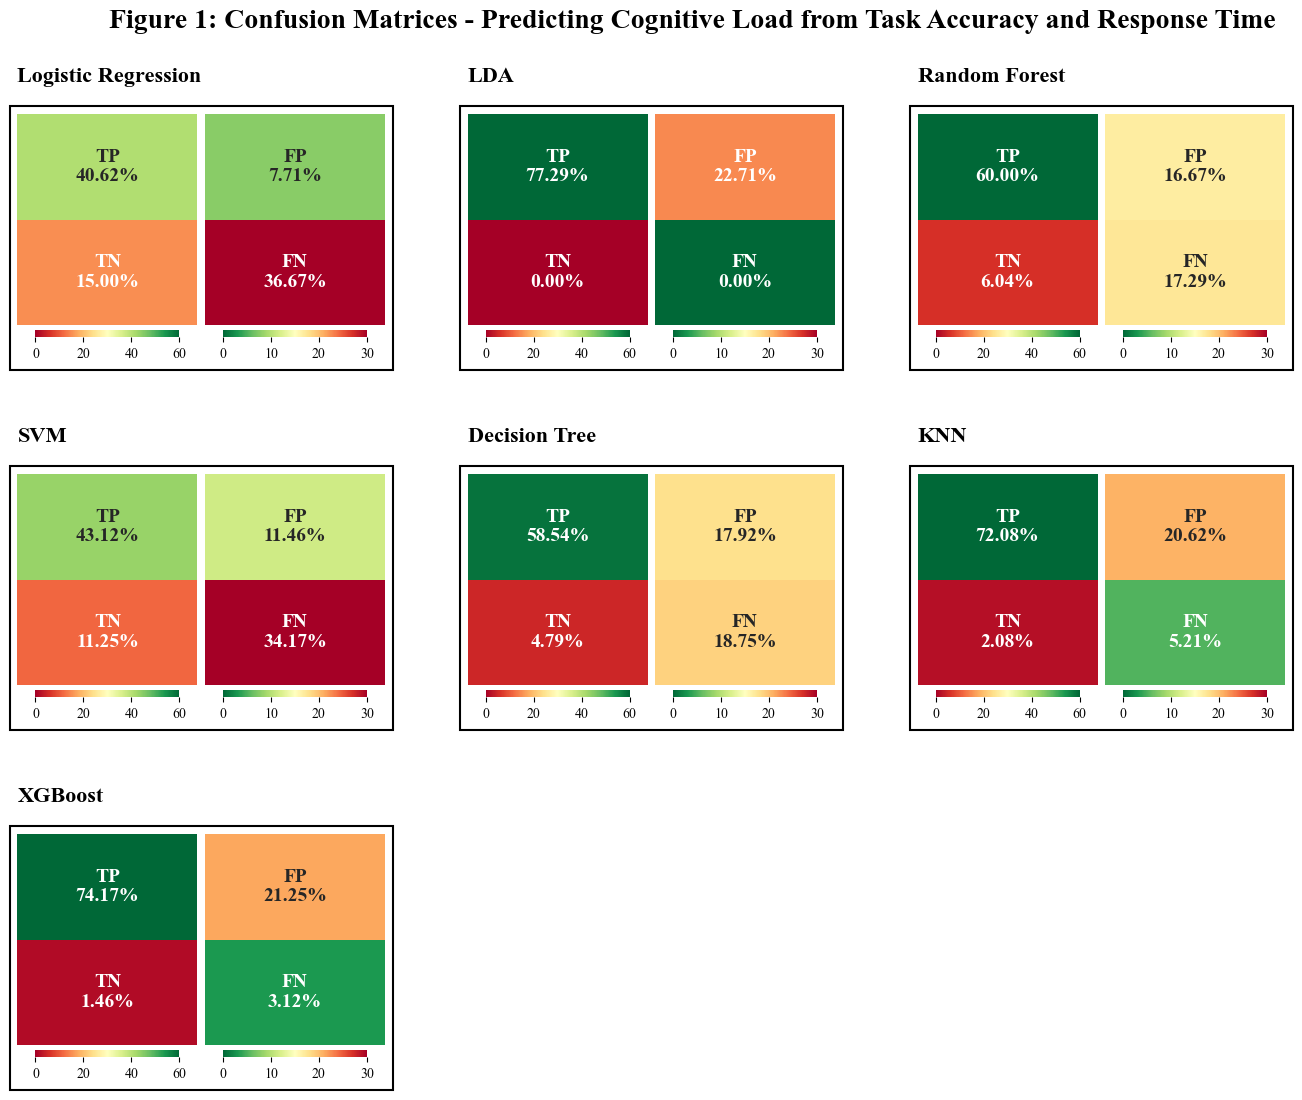

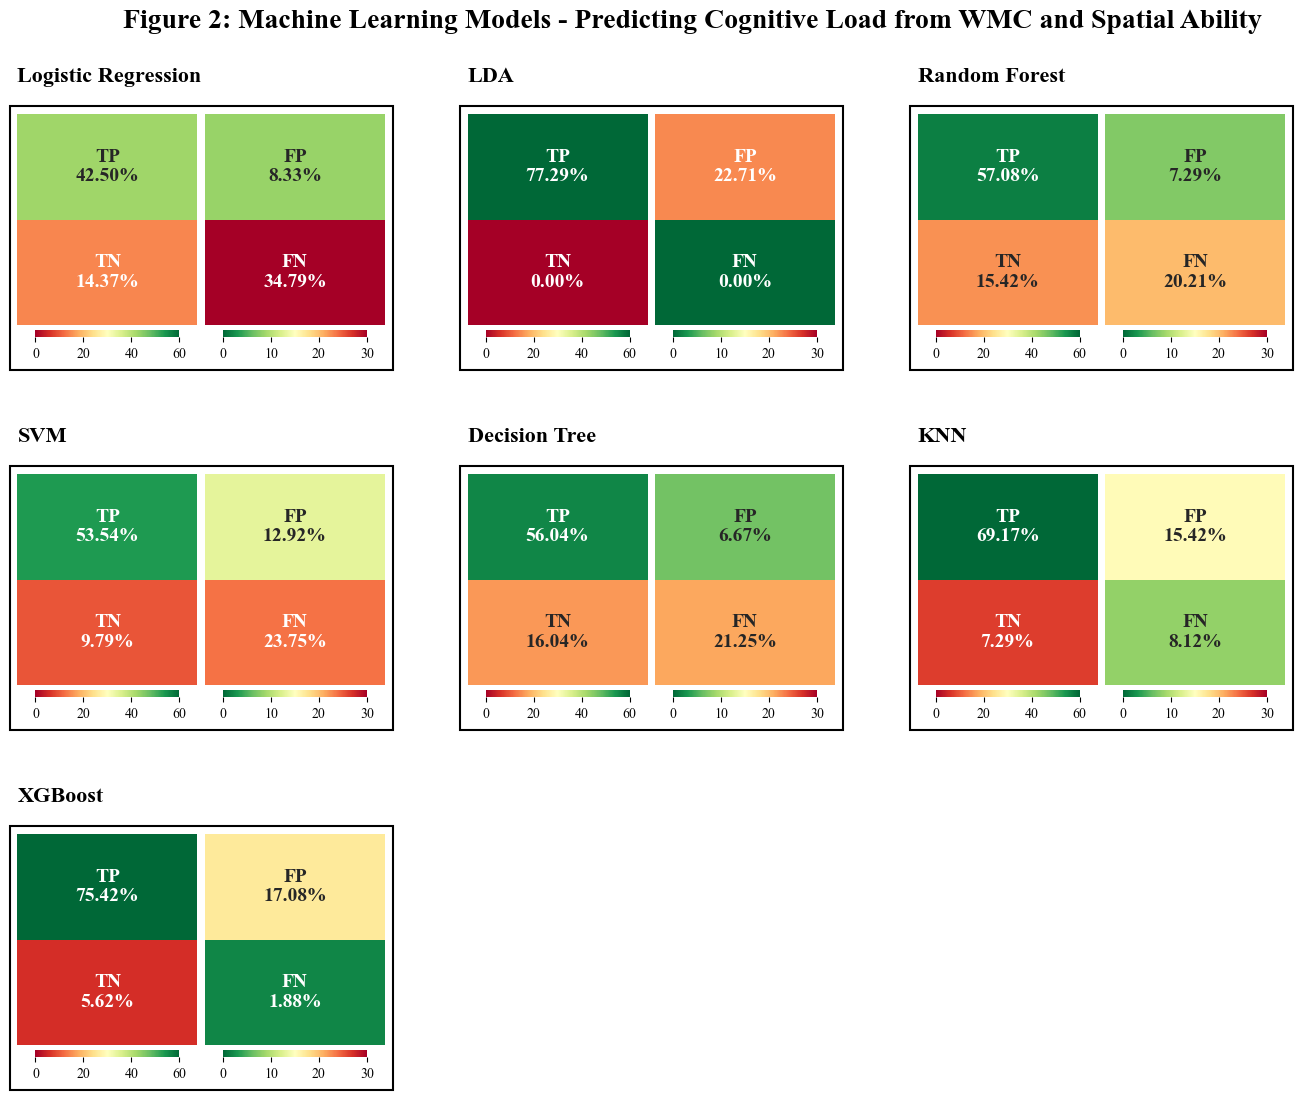

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'

def plot_dual_scale_conf_matrix(matrix, title, fig, position):
    TN, FP, FN, TP = matrix.ravel()
    total = TN + FP + FN + TP

    reordered = np.array([
      [TP,  FP],
      [TN,  FN],
    ])
    percent = reordered/total * 100

    labels = np.array([
      [f"TP\n{percent[0,0]:.2f}%", f"FP\n{percent[0,1]:.2f}%"],
      [f"TN\n{percent[1,0]:.2f}%", f"FN\n{percent[1,1]:.2f}%"],
    ])

    heatmap_w = 0.12
    heatmap_h = 0.30
    spacing  = 0.005

    # Left half
    ax_l = fig.add_axes([position[0], position[1], heatmap_w, heatmap_h])
    sns.heatmap(
        [[percent[0,0]], [percent[1,0]]],
        annot=[[labels[0,0]], [labels[1,0]]],
        fmt='',
        cmap='RdYlGn',
        vmin=0, vmax=60,
        cbar=True,
        cbar_kws={'orientation':'horizontal','fraction':0.1,'pad':0.02,'shrink':0.8,'ticks':[0,20,40,60]},
        xticklabels=False,
        yticklabels=False,
        annot_kws={'weight':'bold','fontsize':14},
        ax=ax_l
    )

    # Right half
    ax_r = fig.add_axes([
        position[0] + heatmap_w + spacing,
        position[1],
        heatmap_w,
        heatmap_h
    ])
    sns.heatmap(
        [[percent[0,1]], [percent[1,1]]],
        annot=[[labels[0,1]], [labels[1,1]]],
        fmt='',
        cmap='RdYlGn_r',
        vmin=0, vmax=30,
        cbar=True,
        cbar_kws={'orientation':'horizontal','fraction':0.1,'pad':0.02,'shrink':0.8,'ticks':[0,10,20,30]},
        xticklabels=False,
        yticklabels=False,
        annot_kws={'weight':'bold','fontsize':14},
        ax=ax_r
    )

    rect = patches.Rectangle(
        (position[0]-0.005, position[1]-0.02),
        2*heatmap_w + spacing + 0.01,
        heatmap_h + 0.03,
        linewidth=1.5,
        edgecolor='black',
        facecolor='none'
    )
    fig.add_artist(rect)

    fig.text(
        position[0],
        position[1] + heatmap_h + 0.04,
        title, ha='left', fontsize=16, fontweight='bold'
    )

all_keys = list(confusion_matrices.keys())
labels = sorted({k.split('_')[0] + '_' + k.split('_')[1] for k in all_keys})

for label in labels:
    models = []
    for k, cm in confusion_matrices.items():
        if k.startswith(label + "_"):
            model_name = k[len(label)+1:]
            models.append((model_name, cm))

    fig = plt.figure(figsize=(15, 8))
    if label == "H1_states":
        fig.suptitle("Figure 1: Confusion Matrices - Predicting Cognitive Load from Task Accuracy and Response Time", fontsize=20, fontweight='bold')
    elif label == "H2_traits":
        fig.suptitle("Figure 2: Machine Learning Models - Predicting Cognitive Load from WMC and Spatial Ability", fontsize=20, fontweight='bold')
    else:
        fig.suptitle(f"Confusion Matrices for {label}", fontsize=20, fontweight='bold')

    for idx, (model, cm) in enumerate(models):
        row = idx // 3
        col = idx % 3
        cell_w = 0.28
        cell_h = 0.40
        x0 = 0.05 + col * (cell_w + 0.02)
        y0 = 0.55 - row * (cell_h + 0.05)
        plot_dual_scale_conf_matrix(cm, model, fig, (x0, y0))

    plt.show()

## For All Blocks

In [ ]:
warnings.filterwarnings("ignore")

master_df = pd.read_csv("master.csv")

confusion_matrices = {}

labels = [
    "tutorial_split_feedback_score_subexperiment",
    # "quartile_split_feedback_score_subexperiment",
    # "median_split_feedback_score_subexperiment",
]

features = [
    "accuracy_subexperiment",
    "trial_duration_mean",
    "nback_composite_2",
    "MRTAcc",
]

base_param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-3, 3, 10),
        "penalty": ["l2"],
        "solver": ["lbfgs"],
    },
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": [None, "auto", 0.1, 0.3, 0.5, 0.7, 0.9],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "SVM": {
        "C": np.logspace(-3, 3, 10),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },
}

def mean_ci(arr, alpha=0.05):
    arr = np.asarray(arr)
    lower = np.percentile(arr, 100 * alpha / 2)
    upper = np.percentile(arr, 100 * (1 - alpha / 2))
    return arr.mean(), lower, upper

for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not found in dataset. Skipping.")
        continue

    print(f"\n=== Label: {label} ===")
    df = master_df.dropna(subset=[label])

    if df[label].nunique() < 2:
        print("\n--- All Blocks Combined ---")
        print("  Only one class present, skipping.")
        continue

    print("\n--- All Blocks Combined ---")
    print("    Full class distribution:")
    print(df[label].value_counts().to_string())

    X_block = df[features].copy()
    y_block = df[label].copy()

    # outer stratified CV (5-fold)
    outer_cv = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=42
    )

    classifiers_to_tune = [
        ("Logistic Regression", LogisticRegression(class_weight="balanced", max_iter=1000)),
        ("LDA",                 LinearDiscriminantAnalysis()),
        ("Random Forest",       RandomForestClassifier(class_weight="balanced", random_state=42)),
        ("SVM",                 SVC(class_weight="balanced", probability=True, random_state=42)),
        ("Decision Tree",       DecisionTreeClassifier(class_weight="balanced", random_state=42)),
        ("KNN",                 KNeighborsClassifier()),
    ]

    for clf_name, clf in classifiers_to_tune:
        print(f"  Model: {clf_name}")
        pg_pref = {f"model__{k}": v for k, v in base_param_grids[clf_name].items()}
        
        y_true_all = []
        y_pred_all = []
        
        pipe = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("model", clf),
            ]
        )

        # inner search (5-fold)
        search = RandomizedSearchCV(
            pipe,
            param_distributions=pg_pref,
            n_iter=100,
            cv=5,
            scoring="f1_weighted",
            random_state=42,
            n_jobs=-1,
        )
        
        tr_f1, tr_acc, tr_prec, tr_rec = [], [], [], []
        te_f1, te_acc, te_prec, te_rec = [], [], [], []

        # outer loop
        for train_idx, test_idx in outer_cv.split(X_block, y_block):
            X_tr, X_te = X_block.iloc[train_idx], X_block.iloc[test_idx]
            y_tr, y_te = y_block.iloc[train_idx], y_block.iloc[test_idx]

            search.fit(X_tr, y_tr)
            best_pipe = search.best_estimator_

            y_tr_pred = best_pipe.predict(X_tr)
            y_te_pred = best_pipe.predict(X_te)
            
            y_true_all.extend(y_te)
            y_pred_all.extend(y_te_pred)

            tr_f1.append(f1_score(y_tr, y_tr_pred, average="weighted"))
            te_f1.append(f1_score(y_te, y_te_pred, average="weighted"))

            tr_acc.append(accuracy_score(y_tr, y_tr_pred))
            te_acc.append(accuracy_score(y_te, y_te_pred))

            tr_prec.append(precision_score(y_tr, y_tr_pred, average="weighted", zero_division=0))
            te_prec.append(precision_score(y_te, y_te_pred, average="weighted", zero_division=0))

            tr_rec.append(recall_score(y_tr, y_tr_pred, average="weighted"))
            te_rec.append(recall_score(y_te, y_te_pred, average="weighted"))

        mt, lt, ut = mean_ci(tr_f1)
        print(f"    Training F1        = {mt:.4f} [{lt:.4f}, {ut:.4f}]")
        ma, la, ua = mean_ci(tr_acc)
        print(f"    Training Accuracy  = {ma:.4f} [{la:.4f}, {ua:.4f}]")
        mp, lp, up = mean_ci(tr_prec)
        print(f"    Training Precision = {mp:.4f} [{lp:.4f}, {up:.4f}]")
        mr, lr, ur = mean_ci(tr_rec)
        print(f"    Training Recall    = {mr:.4f} [{lr:.4f}, {ur:.4f}]")

        mt, lt, ut = mean_ci(te_f1)
        print(f"    Test F1            = {mt:.4f} [{lt:.4f}, {ut:.4f}]")
        ma, la, ua = mean_ci(te_acc)
        print(f"    Test Accuracy      = {ma:.4f} [{la:.4f}, {ua:.4f}]")
        mp, lp, up = mean_ci(te_prec)
        print(f"    Test Precision     = {mp:.4f} [{lp:.4f}, {up:.4f}]")
        mr, lr, ur = mean_ci(te_rec)
        print(f"    Test Recall        = {mr:.4f} [{lr:.4f}, {ur:.4f}]")

        cm = confusion_matrix(y_true_all, y_pred_all)
        key = f"{label}_block{block}_{clf_name}"
        confusion_matrices[key] = cm

        search.fit(X_block, y_block)
        best_pipe = search.best_estimator_
        best_est  = best_pipe.named_steps["model"]
        print(f"    Best params: {search.best_params_}")

        if label == labels[0]:
            if hasattr(best_est, "feature_importances_"):
                importances = best_est.feature_importances_
            elif hasattr(best_est, "coef_"):
                importances = np.abs(best_est.coef_).ravel()
            else:
                importances = None

            if importances is not None:
                fi = (
                    pd.Series(importances, index=features)
                    .sort_values(ascending=False)
                )
                print("    Feature importances:")
                for fname, fval in fi.items():
                    print(f"      {fname}: {fval:.4f}")


=== Label: tutorial_split_feedback_score_subexperiment ===

--- All Blocks Combined ---
    Full class distribution:
tutorial_split_feedback_score_subexperiment
1    371
0    109
  Model: Logistic Regression
    Training F1        = 0.6703 [0.6600, 0.6826]
    Training Accuracy  = 0.6417 [0.6307, 0.6552]
    Training Precision = 0.7544 [0.7474, 0.7604]
    Training Recall    = 0.6417 [0.6307, 0.6552]
    Test F1            = 0.6471 [0.5932, 0.7065]
    Test Accuracy      = 0.6188 [0.5646, 0.6833]
    Test Precision     = 0.7468 [0.7119, 0.7834]
    Test Recall        = 0.6188 [0.5646, 0.6833]
    Best params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 0.1}
    Feature importances:
      trial_duration_mean: 0.4789
      nback_composite_2: 0.3185
      accuracy_subexperiment: 0.2513
      MRTAcc: 0.1415
  Model: LDA
    Training F1        = 0.6944 [0.6823, 0.7031]
    Training Accuracy  = 0.7760 [0.7687, 0.7810]
    Training Precision = 0.7360 [0.6791, 0.7888]
    T

### Logistic Regression Visualization

### Confusion Matrix for All Blocks

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'

def plot_dual_scale_conf_matrix(matrix, title, fig, position):
    matrix = np.array(matrix)
    total  = matrix.sum()

    # extract sklearn cells (tn, fp; fn, tp)
    tn, fp = matrix[0,0], matrix[0,1]
    fn, tp = matrix[1,0], matrix[1,1]

    print(f"{title} → TP={tp}, FP={fp}, TN={tn}, FN={fn}, total={total}")

    # reorder into [ [TP, FP], [TN, FN] ]
    reordered = np.array([
        [tp, fp],
        [tn, fn],
    ])
    percent = (reordered / total) * 100

    labels = np.array([
        [f"TP\n{percent[0,0]:.2f}%", f"FP\n{percent[0,1]:.2f}%"],
        [f"TN\n{percent[1,0]:.2f}%", f"FN\n{percent[1,1]:.2f}%"],
    ])

    heatmap_w = 0.12
    heatmap_h = 0.30
    spacing  = 0.005

    # Left half: TP over TN
    ax_l = fig.add_axes([position[0], position[1], heatmap_w, heatmap_h])
    sns.heatmap(
        [[percent[0,0]], [percent[1,0]]],
        annot=[[labels[0,0]], [labels[1,0]]],
        fmt='', cmap='RdYlGn', vmin=0, vmax=60,
        cbar=True, cbar_kws={
          'orientation':'horizontal',
          'fraction':0.1,
          'pad':0.02,
          'shrink':0.8,
          'ticks':[0,20,40,60]
        },
        xticklabels=False, yticklabels=False,
        annot_kws={'weight':'bold','fontsize':14},
        ax=ax_l
    )

    # Right half: FP over FN
    ax_r = fig.add_axes([
        position[0] + heatmap_w + spacing,
        position[1],
        heatmap_w,
        heatmap_h
    ])
    sns.heatmap(
        [[percent[0,1]], [percent[1,1]]],
        annot=[[labels[0,1]], [labels[1,1]]],
        fmt='', cmap='RdYlGn_r', vmin=0, vmax=30,
        cbar=True, cbar_kws={
          'orientation':'horizontal',
          'fraction':0.1,
          'pad':0.02,
          'shrink':0.8,
          'ticks':[0,10,20,30]
        },
        xticklabels=False, yticklabels=False,
        annot_kws={'weight':'bold','fontsize':14},
        ax=ax_r
    )

    rect = patches.Rectangle(
        (position[0]-0.005, position[1]-0.02),
        2*heatmap_w + spacing + 0.01,
        heatmap_h + 0.03,
        linewidth=1.5, edgecolor='black', facecolor='none'
    )
    fig.add_artist(rect)

    fig.text(
        position[0],
        position[1] + heatmap_h + 0.04,
        title, ha='left', fontsize=16, fontweight='bold'
    )

for label in labels:
    keys = [k for k in confusion_matrices if k.startswith(f"{label}_")]
    if not keys:
        print(f"No confusion matrices found for {label}")
        continue

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f"{label} — All Blocks Combined", fontsize=20, fontweight='bold')

    for idx, key in enumerate(sorted(keys)):
        model = key.split(f"{label}_",1)[1]
        cm    = confusion_matrices[key]

        row = idx // 3  # 0 or 1
        col = idx %  3  # 0,1,2
        cell_w = 0.28
        cell_h = 0.40
        x0 = 0.05 + col * (cell_w + 0.02)
        y0 = 0.55 - row * (cell_h + 0.05)

        plot_dual_scale_conf_matrix(cm, model, fig, (x0, y0))

    plt.show()

No confusion matrices found for tutorial_split_feedback_score_subexperiment


## Per Block

In [39]:
warnings.filterwarnings("ignore")

master_df = pd.read_csv("master.csv")

confusion_matrices = {}

labels = [
    "tutorial_split_feedback_score_subexperiment",
    # "quartile_split_feedback_score_subexperiment",
    # "median_split_feedback_score_subexperiment",
]

features = [
    "accuracy_subexperiment",
    "trial_duration_mean",
    "nback_composite_2",
    "MRTAcc",
]

base_param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-3, 3, 10),
        "penalty": ["l2"],
        "solver": ["lbfgs"],
    },
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": [None, "auto", 0.1, 0.3, 0.5, 0.7, 0.9],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "SVM": {
        "C": np.logspace(-3, 3, 10),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },
}

def mean_ci(arr, alpha=0.05):
    arr = np.asarray(arr)
    lower = np.percentile(arr, 100 * alpha / 2)
    upper = np.percentile(arr, 100 * (1 - alpha / 2))
    return arr.mean(), lower, upper

for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not found in dataset. Skipping.")
        continue

    print(f"\n=== Label: {label} ===")
    df = master_df.dropna(subset=[label])

    for block in sorted(df["subexperiment_number"].unique()):
        block_df = df[df["subexperiment_number"] == block]

        if block_df[label].nunique() < 2:
            print(f"\n--- Block: {block} ---")
            print("  Only one class present, skipping.")
            continue

        print(f"\n--- Block: {block} ---")
        print("    Full block class distribution:")
        print(block_df[label].value_counts().to_string())

        X_block = block_df[features].copy()
        y_block = block_df[label].copy()

        # outer stratified CV (5-fold)
        outer_cv = StratifiedKFold(
            n_splits=5, shuffle=True, random_state=42
        )

        classifiers_to_tune = [
            ("Logistic Regression", LogisticRegression(class_weight="balanced", max_iter=1000)),
            ("LDA",                 LinearDiscriminantAnalysis()),
            ("Random Forest",       RandomForestClassifier(class_weight="balanced", random_state=42)),
            ("SVM",                 SVC(class_weight="balanced", probability=True, random_state=42)),
            ("Decision Tree",       DecisionTreeClassifier(class_weight="balanced", random_state=42)),
            ("KNN",                 KNeighborsClassifier()),
        ]

        for clf_name, clf in classifiers_to_tune:
            print(f"  Model: {clf_name}")
            pg_pref = {f"model__{k}": v for k, v in base_param_grids[clf_name].items()}
            
            y_true_all = []
            y_pred_all = []
            
            pipe = Pipeline(
                steps=[
                    ("scaler", StandardScaler()),
                    ("model", clf),
                ]
            )

            # inner search (5-fold)
            search = RandomizedSearchCV(
                pipe,
                param_distributions=pg_pref,
                n_iter=100,
                cv=5,
                scoring="f1_weighted",
                random_state=42,
                n_jobs=-1,
            )
            
            tr_f1, tr_acc, tr_prec, tr_rec = [], [], [], []
            te_f1, te_acc, te_prec, te_rec = [], [], [], []

            # outer loop
            for train_idx, test_idx in outer_cv.split(X_block, y_block):
                X_tr, X_te = X_block.iloc[train_idx], X_block.iloc[test_idx]
                y_tr, y_te = y_block.iloc[train_idx], y_block.iloc[test_idx]

                search.fit(X_tr, y_tr)
                best_pipe = search.best_estimator_

                y_tr_pred = best_pipe.predict(X_tr)
                y_te_pred = best_pipe.predict(X_te)
                
                y_true_all.extend(y_te)
                y_pred_all.extend(y_te_pred)

                tr_f1.append(f1_score(y_tr, y_tr_pred, average="weighted"))
                te_f1.append(f1_score(y_te, y_te_pred, average="weighted"))

                tr_acc.append(accuracy_score(y_tr, y_tr_pred))
                te_acc.append(accuracy_score(y_te, y_te_pred))

                tr_prec.append(precision_score(y_tr, y_tr_pred, average="weighted", zero_division=0))
                te_prec.append(precision_score(y_te, y_te_pred, average="weighted", zero_division=0))

                tr_rec.append(recall_score(y_tr, y_tr_pred, average="weighted"))
                te_rec.append(recall_score(y_te, y_te_pred, average="weighted"))

            mt, lt, ut = mean_ci(tr_f1)
            print(f"    Training F1        = {mt:.4f} [{lt:.4f}, {ut:.4f}]")
            ma, la, ua = mean_ci(tr_acc)
            print(f"    Training Accuracy  = {ma:.4f} [{la:.4f}, {ua:.4f}]")
            mp, lp, up = mean_ci(tr_prec)
            print(f"    Training Precision = {mp:.4f} [{lp:.4f}, {up:.4f}]")
            mr, lr, ur = mean_ci(tr_rec)
            print(f"    Training Recall    = {mr:.4f} [{lr:.4f}, {ur:.4f}]")

            mt, lt, ut = mean_ci(te_f1)
            print(f"    Test F1            = {mt:.4f} [{lt:.4f}, {ut:.4f}]")
            ma, la, ua = mean_ci(te_acc)
            print(f"    Test Accuracy      = {ma:.4f} [{la:.4f}, {ua:.4f}]")
            mp, lp, up = mean_ci(te_prec)
            print(f"    Test Precision     = {mp:.4f} [{lp:.4f}, {up:.4f}]")
            mr, lr, ur = mean_ci(te_rec)
            print(f"    Test Recall        = {mr:.4f} [{lr:.4f}, {ur:.4f}]")

            cm = confusion_matrix(y_true_all, y_pred_all)
            key = f"{label}_block{block}_{clf_name}"
            confusion_matrices[key] = cm

            search.fit(X_block, y_block)
            best_pipe = search.best_estimator_
            best_est  = best_pipe.named_steps["model"]
            print(f"    Best params: {search.best_params_}")

            if label == labels[0]:
                if hasattr(best_est, "feature_importances_"):
                    importances = best_est.feature_importances_
                elif hasattr(best_est, "coef_"):
                    importances = np.abs(best_est.coef_).ravel()
                else:
                    importances = None

                if importances is not None:
                    fi = (
                        pd.Series(importances, index=features)
                        .sort_values(ascending=False)
                    )
                    print("    Feature importances:")
                    for fname, fval in fi.items():
                        print(f"      {fname}: {fval:.4f}")


=== Label: tutorial_split_feedback_score_subexperiment ===

--- Block: 1 ---
    Full block class distribution:
tutorial_split_feedback_score_subexperiment
1    35
0    25
  Model: Logistic Regression
    Training F1        = 0.6639 [0.6470, 0.6874]
    Training Accuracy  = 0.6625 [0.6458, 0.6854]
    Training Precision = 0.6792 [0.6566, 0.7050]
    Training Recall    = 0.6625 [0.6458, 0.6854]
    Test F1            = 0.5738 [0.4743, 0.7412]
    Test Accuracy      = 0.5833 [0.5000, 0.7417]
    Test Precision     = 0.6066 [0.5029, 0.7542]
    Test Recall        = 0.5833 [0.5000, 0.7417]
    Best params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 0.001}
    Feature importances:
      trial_duration_mean: 0.0074
      accuracy_subexperiment: 0.0053
      MRTAcc: 0.0024
      nback_composite_2: 0.0023
  Model: LDA
    Training F1        = 0.6546 [0.6203, 0.6812]
    Training Accuracy  = 0.6625 [0.6292, 0.6854]
    Training Precision = 0.6585 [0.6217, 0.6819]
    Traini

### Confusion Matrix

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'

# reuse your existing helper unchanged:
def plot_dual_scale_conf_matrix(matrix, title, fig, position):
    matrix = np.array(matrix)
    total = matrix.sum()
    reordered = np.array([
        [matrix[0,0], matrix[0,1]],
        [matrix[1,1], matrix[1,0]]
    ])
    percent = (reordered / total) * 100
    labels = np.array([
        [f"TP\n{percent[0,0]:.2f}%", f"FP\n{percent[0,1]:.2f}%"],
        [f"TN\n{percent[1,0]:.2f}%", f"FN\n{percent[1,1]:.2f}%"],
    ])

    heatmap_w = 0.12
    heatmap_h = 0.30
    spacing  = 0.005

    # Left half
    ax_l = fig.add_axes([position[0], position[1], heatmap_w, heatmap_h])
    hm_l = sns.heatmap(
        [[percent[0,0]],[percent[1,0]]],
        annot=[[labels[0,0]],[labels[1,0]]],
        fmt='', cmap='RdYlGn', vmin=0, vmax=60,
        cbar=True, cbar_kws={
          'orientation':'horizontal','fraction':0.1,'pad':0.02,'shrink':0.8,'ticks':[0,20,40,60]
        },
        xticklabels=False, yticklabels=False,
        annot_kws={'weight':'bold','fontsize':14},
        ax=ax_l
    )
    # Right half
    ax_r = fig.add_axes([
        position[0] + heatmap_w + spacing,
        position[1],
        heatmap_w,
        heatmap_h
    ])
    hm_r = sns.heatmap(
        [[percent[0,1]],[percent[1,1]]],
        annot=[[labels[0,1]],[labels[1,1]]],
        fmt='', cmap='RdYlGn_r', vmin=0, vmax=30,
        cbar=True, cbar_kws={
          'orientation':'horizontal','fraction':0.1,'pad':0.02,'shrink':0.8,'ticks':[0,10,20,30]
        },
        xticklabels=False, yticklabels=False,
        annot_kws={'weight':'bold','fontsize':14},
        ax=ax_r
    )

    # border
    rect = patches.Rectangle(
        (position[0]-0.005, position[1]-0.02),
        2*heatmap_w + spacing + 0.01,
        heatmap_h + 0.03,
        linewidth=1.5, edgecolor='black', facecolor='none'
    )
    fig.add_artist(rect)

    # title above
    fig.text(
        position[0],
        position[1] + heatmap_h + 0.04,
        title, ha='left', fontsize=16, fontweight='bold'
    )

# ---- now: loop per block, 1 figure each with 6 sub-plots ----

for label in labels:
    # collect all keys for this label
    keys = [k for k in confusion_matrices if k.startswith(label)]
    # group by block number
    from collections import defaultdict
    by_block = defaultdict(list)
    for k in keys:
        # key = "label_blockN_ModelName"
        parts = k.split('_')
        block = parts[-2]      # "block1", "block2", ...
        model = parts[-1]
        by_block[block].append((model, confusion_matrices[k]))

    for block, models in sorted(by_block.items(), key=lambda x: int(x[0][5:])):
        fig = plt.figure(figsize=(15, 8))
        fig.suptitle(f"{label} {block} Confusion Matrices", fontsize=20, fontweight='bold')

        # 2 rows × 3 columns
        for idx, (model, cm) in enumerate(models):
            row = idx // 3        # 0 or 1
            col = idx %  3        # 0, 1, 2

            # normalize to [0,1] figure coords:
            cell_w = 0.28
            cell_h = 0.40
            x0 = 0.05 + col * (cell_w + 0.02)
            y0 = 0.55 - row * (cell_h + 0.05)

            title = model
            plot_dual_scale_conf_matrix(cm, title, fig, (x0, y0))

        plt.show()

In [48]:
# Print the data distribution in the dataset per block (group by subexperiment_number from 1 to 8 inclusive, and for each block, print the number of 0s and 1s in the tutorial_split_feedback_score_subexperiment column)
for block in range(1, 9):
    block_df = master_df[master_df['subexperiment_number'] == block]
    if block_df.empty:
        print(f"Block {block}: No data available.")
        continue
    
    counts = block_df['tutorial_split_feedback_score_subexperiment'].value_counts()
    num_0s = counts.get(0, 0)
    num_1s = counts.get(1, 0)
    
    print(f"Block {block}: 0s = {num_0s}, 1s = {num_1s}")

Block 1: 0s = 25, 1s = 35
Block 2: 0s = 24, 1s = 36
Block 3: 0s = 16, 1s = 44
Block 4: 0s = 18, 1s = 42
Block 5: 0s = 7, 1s = 53
Block 6: 0s = 6, 1s = 54
Block 7: 0s = 8, 1s = 52
Block 8: 0s = 5, 1s = 55
